<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_09/Part_02_1_transfer_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Imports and Setup

In [1]:
# Step 1: Imports and Setup
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Enable GPU memory growth if needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)


##  Step 2: Load Cats vs Dogs Dataset

In [2]:
(train_ds, val_ds), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 224
BATCH_SIZE = 32

# Preprocessing pipeline
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image / 255.0, label

train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.LIJRGU_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


##  Step 3: Feature Extraction with MobileNetV2 (Frozen Base)

In [3]:
# Load base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze base

# Create model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train only the classification head
history = model.fit(train_ds, validation_data=val_ds, epochs=5)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - accuracy: 0.9453 - loss: 0.1381 - val_accuracy: 0.9847 - val_loss: 0.0436
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - accuracy: 0.9844 - loss: 0.0447 - val_accuracy: 0.9847 - val_loss: 0.0409
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.9860 - loss: 0.0390 - val_accuracy: 0.9852 - val_loss: 0.0405
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9882 - loss: 0.0357 - val_accuracy: 0.9856 - val_loss: 0.0406
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.9887 - loss: 0.0329 - val_accuracy: 0.9862 - val_loss: 0.0413


## Step 4: Fine-Tuning the Top Layers

In [4]:
# Unfreeze top layers of base model
base_model.trainable = True

# Freeze all layers before layer 100
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the entire stack
fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 68s 83ms/step - accuracy: 0.9276 - loss: 0.1850 - val_accuracy: 0.9800 - val_loss: 0.0675
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.9799 - loss: 0.0543 - val_accuracy: 0.9817 - val_loss: 0.0521
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.9893 - loss: 0.0337 - val_accuracy: 0.9837 - val_loss: 0.0471
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9902 - loss: 0.0274 - val_accuracy: 0.9826 - val_loss: 0.0490
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.9954 - loss: 0.0161 - val_accuracy: 0.9837 - val_loss: 0.0478


##  Step 5: Plot Results

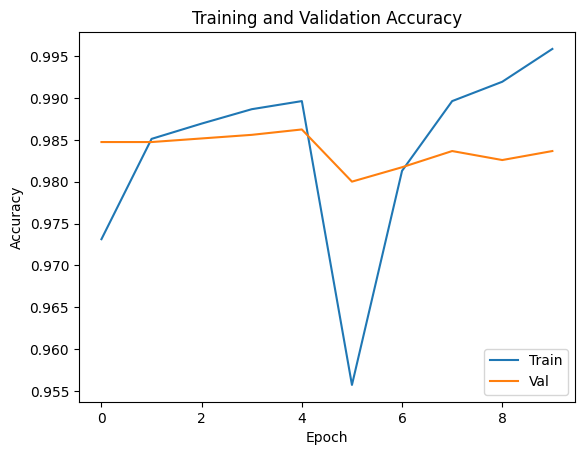

In [5]:
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'])
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()